In [65]:
%pip install scienceplots
############################################
# Plotting boilerplate
from matplotlib.rcsetup import cycler
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


standard_colors = [
    c["color"] for c in plt.style.library["std-colors"]["axes.prop_cycle"]
]
crest_colors = lambda n:  list(sns.color_palette("crest", n_colors=n))
flare_colors = lambda n: list(sns.color_palette("flare", n_colors=n))
circular_colors = lambda n: list(sns.color_palette("husl", n_colors=n))


plt.style.library["science"]["axes.prop_cycle"] = cycler(color=circular_colors(8))
plt.style.use("science")
# figure size in inches, use golden ratio
matplotlib.rcParams['figure.figsize'] = (4.85, 3) 
matplotlib.rcParams["figure.dpi"] = 200
# default figure.dpi: 200


def plot(fn, *fn_args,  title=None, legend=None, xlabel=None, ylabel=None, rotate: int =None, **fn_kwargs,):    
    # plt.plot(*line2_xy)
    ret = fn(*fn_args, **fn_kwargs)

    if legend is not None:
        plt.legend() if legend is True else plt.legend(legend)

    if rotate is not None:
        # rotate xlabels by `rotate` degrees`
        plt.setp(plt.gca().get_xticklabels(), rotation=rotate, horizontalalignment="right")


    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return ret

def confidence(x, y, y_err, **kwargs):
    plt.plot(x, y, **kwargs)
    plt.fill_between(x, y + y_err, y - y_err, alpha=.2, label='_')

def correlation(*args, **kwargs):
    if kwargs.get('figsize') is None:
        kwargs['figsize'] = (9, 11)
    plt.figure(figsize=kwargs['figsize'])
    kwargs.pop('figsize')

    if kwargs.get('cmap') is None:
        kwargs["cmap"] = sns.diverging_palette(230, 20, as_cmap=True)
    if kwargs.get('mask') is None:
        kwargs["mask"] = np.triu(np.ones_like(args[0], dtype=bool))
    if isinstance(kwargs['mask'], bool) and kwargs['mask'] == False:
        kwargs["mask"] = None

    plot(sns.heatmap, *args, **kwargs)
    plt.gca().tick_params(
        top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True
    )
    plt.minorticks_off()

np.set_printoptions(precision=4, suppress=True)

# plt.style.library["science"]
########################################3

Looking in indexes: http://nginx.pypi.svc.cluster.local/simple/
Note: you may need to restart the kernel to use updated packages.


In [188]:
import wandb
api = wandb.Api(timeout=600)


run_ids = [
'msho/gfn4ntp/lwbdpxmd',
'msho/gfn4ntp/df6r5u2g',
'msho/gfn4ntp/fzlq4xfq',
'openai/gfn4ntp/ullaxn8z'
]
runs = [api.run(i) for i in run_ids]

In [189]:
runs[0].name

'train1k_rm'

In [203]:
sch = runs[0].scan_history()

In [211]:
keys = ['val/logR', 'val/num_proved', 'val/loss', 'train/loss', 'train/logR', 'trainer/global_step']

histories = []
import pandas as pd
for i in runs:
    history_scan = i.scan_history()
    vals = defaultdict(list)
    for row in history_scan:
        for k in keys:
            try:
                vals[k].append(row[k])
            except KeyError:
                vals[k].append(None)
            
                    
    histories.append(pd.DataFrame(vals))

In [192]:
keys = ['val/logR', 'val/num_proved', 'val/loss', 'train/loss', 'train/logR']

histories = [i.history(samples=2000) for i in runs]

In [212]:
histories[0]['val/num_proved'].dropna()

20      0.0
41      1.0
62      2.0
83      4.0
104     4.0
       ... 
2018    5.0
2039    5.0
2060    6.0
2081    5.0
2102    5.0
Name: val/num_proved, Length: 100, dtype: float64

In [213]:
from collections import defaultdict
losses = []
values = defaultdict(list)

for k in keys:
    window = 100
    for i, h in enumerate(histories):
        series = h[k].dropna()
        if len(series) < 200:
            window = 1

        idx = h['trainer/global_step'][series.index[window-1:]]
        #  k == 'val/num_proved' or k == 'val/logR'
        if runs[i].name == 'sft':
            idx = (idx / 2).astype('int')
            
        smoothed = series.rolling(window=window).mean()[window-1:]
        values[k].append((smoothed, idx))

In [214]:
runs[1].name

'train1k_raw'

In [220]:
histories[1]['val/num_proved'].dropna()

20      0.0
41      1.0
62      2.0
83      4.0
104     4.0
       ... 
2018    4.0
2039    6.0
2060    6.0
2081    6.0
2102    6.0
Name: val/num_proved, Length: 100, dtype: float64

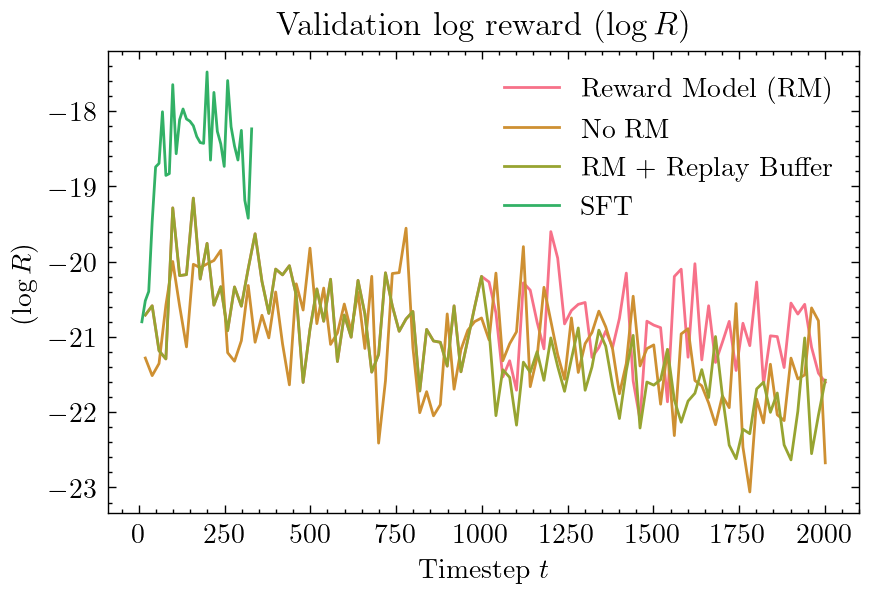

In [249]:


window = 20
import numpy as np

# line1_x, line1_y = ([0, 1, 2], np.array([1, 2, 3]))
# line2_x, line2_y = ([0, 1, 2], np.array([0, 1, 3]))

# plot(confidence, line1_x, line1_y, y_err=0.2, label=r"line 1 $\xi$")

fmt_name = {
    'train1k_rm': 'Reward Model (RM)',
    'train1k_raw': 'No RM',
    'train1k_rm_rb': 'RM + Replay Buffer',
    'sft': 'SFT'
    
}

fmt_title = {
    'val/logR': ("Validation log  reward $(\log R)$", "$(\log R)$"),
    'val/num_proved': ("Number of Theorems Proved over Time", '\# Thm Proved'),
    'val/loss': ("GFN Trajectory Balance (TB) Validation Loss", "Loss $\mathcal{L}_{TB}$"),
    'train/logR': ("Training log  reward $(\log R)$", "$(\log R)$"),
    'train/loss': ("GFN Trajectory Balance (TB) Training Loss", "Loss $\mathcal{L}_{TB}$"),
}

for k in keys[:-1]:
    if k.startswith('train') or k == 'val/loss':
        vals = values[k][:-1]        
        idx, v = values[k][-1]
        plot(plt.plot,
            v,
            idx,
            label=fmt_name[runs[-1].name],
            title=fmt_title[k][0].replace('GFN Trajectory Balance (TB)', 'Supervised Fine-Tuning (SFT)'),
            legend=True,
            xlabel="Timestep $t$",
            ylabel=fmt_title[k][1]
        )
        plt.savefig(fmt_title[k][0].replace('GFN Trajectory Balance (TB)', 'Supervised Fine-Tuning (SFT)'))
        plt.show()

    else:
        vals = values[k]
    for i, (idx, v) in enumerate(vals):
        if i == len(vals) - 1:
            kwargs = dict(
            # title="GFN Trajectory Balance (TB) Training Loss",
            title=fmt_title[k][0],
            legend=True,
            xlabel="Timestep $t$",
            ylabel=fmt_title[k][1]
    )
        else:
            kwargs = {}
        plot(plt.plot,
            v,
            idx,
            label=fmt_name[runs[i].name],
            **kwargs
        )    
    plt.savefig(fmt_title[k][0])
    plt.show()
    break

In [151]:
values['val/num_proved'][0][-1] 

Index([  5,  16,  38,  72, 127, 131, 136, 163, 176, 185, 189, 213, 217, 240,
       276, 284, 291, 329, 366, 395, 416, 470, 499],
      dtype='int64')

In [142]:
(values['val/num_proved'][0][-1] / 2).astype('int')

Index([ 20,  40,  61,  81, 102, 122, 143, 163, 184, 204, 225, 245, 266, 286,
       307, 327, 348, 368, 389, 409, 430, 450, 471, 491, 512, 532],
      dtype='int64')